In [15]:
import numpy as np
import pandas as pd

input_file = "../data/network_backup_dataset.csv"
df = pd.read_csv(input_file, header = 0)
labels = df.columns
for i, v in enumerate(labels):
    print "labels[" + str(i) + "] => " + v

labels[0] => Week #
labels[1] => Day of Week
labels[2] => Backup Start Time - Hour of Day
labels[3] => Work-Flow-ID
labels[4] => File Name
labels[5] => Size of Backup (GB)
labels[6] => Backup Time (hour)


In [16]:
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def convert_to_scalar(typeId, content):
    '''
    return the scalar encoding of the feature
    typeId 1 => Day of the week
    typeId 2 => Hour of the day
    typeId 3 => Work-flow number
    typeId 4 => File-type
    typeId 0 => Week number
    typeId 5 => Size of backup (GB)
    '''
    if typeId == 1:
        return week.index(content) + 1
    elif typeId == 2:
        return int(content)
    elif typeId == 3:
        return int(content.split('_')[2])
    elif typeId == 4:
        return int(content.split('_')[1])
    elif typeId == 0:
        return int(content)
    elif typeId == 5:
        return float(content)
    else:
        raise Exception('invalid typeId')
        
def transform_to_scalar(row):
    '''
    return a transformed scalar row
    parameter row is row in dataset
    '''
    a = []
    for i, v in enumerate(row[:6]):
        a.append(convert_to_scalar(i, v))

    return a

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt 

def plot_result(target, predict, title = ""):
    fig, ax = plt.subplots()
    ax.scatter(target, predict)
    ax.plot([min(target), max(target)], [min(target), max(target)], 'k--', lw = 4)
    ax.set_xlabel('Measured size', fontsize = 20)
    ax.set_ylabel('Predicted size', fontsize = 20)
    plt.title(title + ' Fitted values vs. Actual values')
    plt.show()
    
    fig, ax = plt.subplots()
    ax.scatter(predict, predict - target)
    ax.set_xlabel('Predicted size', fontsize = 20)
    ax.set_ylabel('Residual', fontsize = 20)
    plt.title(title + ' Residuals vs. Fitted value')
    plt.show()

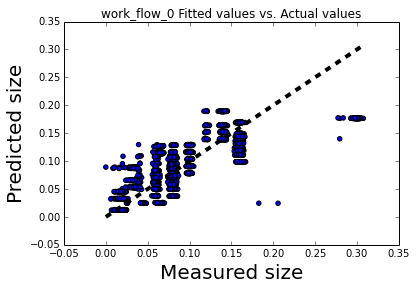

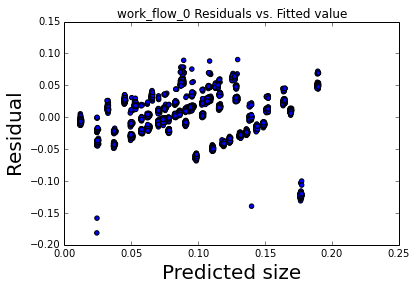

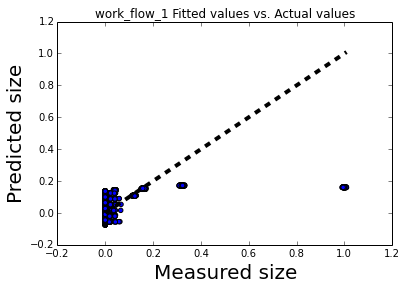

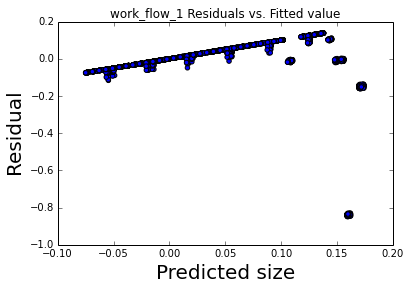

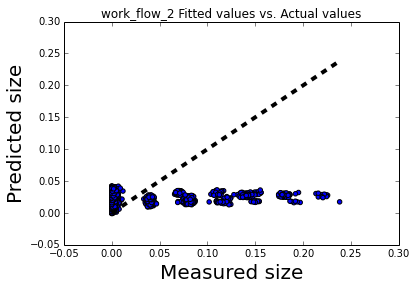

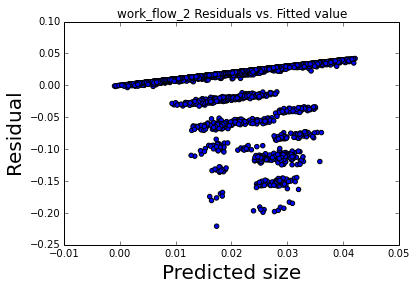

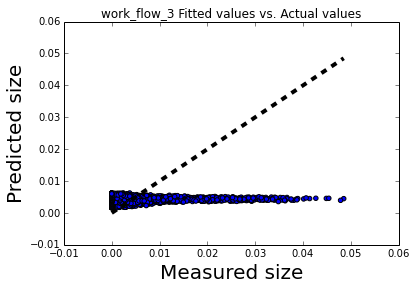

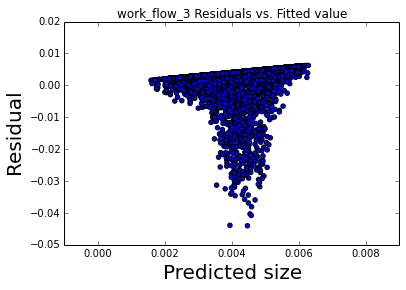

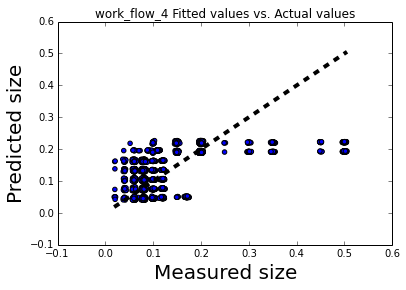

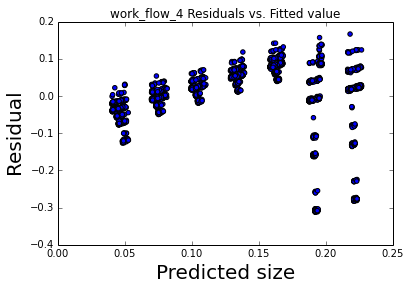

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_predict
from sklearn.model_selection import KFold

for work_flow_id, agg in df.groupby([labels[3]]):
    # get the scalar form of every work_file_id
    dataset_scalar = map(transform_to_scalar, agg.as_matrix())
    # get rid of the work_flow_id
    feature = map(lambda x: x[:3] + x[4:5], dataset_scalar)
    target = map(lambda x: x[5], dataset_scalar)
    
    predict = cross_val_predict(LinearRegression(), feature, target, cv = 10)
    title = str(work_flow_id)
    plot_result(target, predict, title)